In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset
import os
from torchvision import datasets, transforms
from PIL import Image
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# preprocess the data to match mnist sizes as we will use pytorch tutorial

In [4]:
# Training dataset
train_loader  = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)


Batch of data images shape: torch.Size([64, 1, 28, 28])
Batch of target images shape: torch.Size([64])
tensor([7, 3, 0, 5, 6, 6, 5, 5, 3, 2, 0, 5, 6, 8, 2, 6, 4, 6, 3, 6, 5, 1, 6, 9,
        0, 3, 3, 6, 2, 5, 4, 6, 3, 3, 3, 2, 1, 5, 5, 7, 4, 5, 9, 1, 9, 1, 8, 3,
        7, 5, 8, 2, 5, 8, 8, 7, 0, 4, 9, 0, 5, 7, 0, 4])


(-0.5, 27.5, 27.5, -0.5)

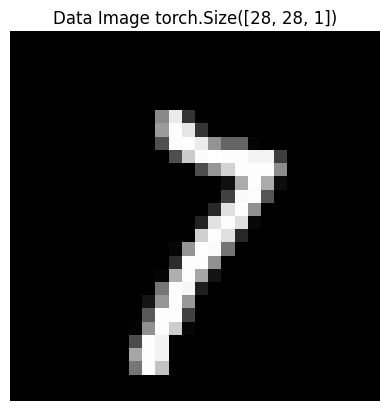

In [5]:
# Fetch a batch of data
data, target = next(iter(train_loader))

# Print the shape of the batch
print("Batch of data images shape:", data.shape)
print("Batch of target images shape:", target.shape)
print(target)

sample = np.transpose(data[0, :, :, :], (1, 2, 0))

# Plot the moving image
plt.title(f'Data Image {sample.shape}')
plt.imshow(sample, cmap='gray')  # Assuming grayscale images
plt.axis('off')

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch, train_loader=None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure the STN performances on MNIST.
#


def test(test_loader = None):
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.713749
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.170428

Test set: Average loss: 0.0389, Accuracy: 9884/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.143370
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.071489

Test set: Average loss: 0.0669, Accuracy: 9795/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.217723
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.102195

Test set: Average loss: 0.0469, Accuracy: 9847/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018205
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.184975

Test set: Average loss: 0.0359, Accuracy: 9893/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.025323
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.148349

Test set: Average loss: 0.0378, Accuracy: 9885/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.061631
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.160879

Test set: Average loss: 0.0435, Accuracy: 9858/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.038408
Train Epoch: 7 [320

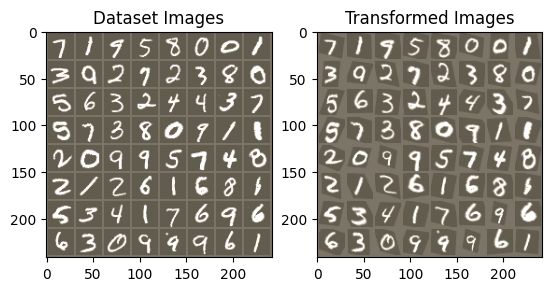

In [32]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn(test_loader=None):
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch, train_loader)
    test(test_loader)

# Visualize the STN transformation on some input batch
visualize_stn(test_loader)

plt.ioff()
plt.show()

Preprocess our data to match mnist shape and channels

In [28]:
class GrayscaleResizeTransform:
    def __init__(self, target_size=(28, 28)):
        self.target_size = target_size

    def __call__(self, img):
        # Convert to grayscale
        img = img.convert('L')

        # Resize the image
        img = img.resize(self.target_size, Image.BILINEAR)  # Use Image.BILINEAR instead of Image.ANTIALIAS
        return img

transform = transforms.Compose([
    GrayscaleResizeTransform(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class ImageRegistrationDataset(Dataset):
    def __init__(self, image_dirs, targets, transform=None):
        self.image_dirs = image_dirs
        self.targets = targets
        self.transform = transform

        # Assuming images are in a common format like JPEG or PNG
        self.images = [os.path.join(self.image_dirs, img) for image_dir, img in zip(image_dirs, os.listdir(image_dirs))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        target = self.targets[idx]

        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, target

# Specify the paths to your fixed and moving image datasets
fixed_images_dir = './fixed/'
moving_images_dir = './moving/'
targets = [1]  # any target, we just have a single image

# Create the dataset
train_dataset_skin = ImageRegistrationDataset(fixed_images_dir, targets, transform=transform)
test_dataset_skin = ImageRegistrationDataset(moving_images_dir, targets, transform=transform)

In [29]:
# Define batch size
batch_size = 64

# Create a data loader
train_loader_skin = torch.utils.data.DataLoader(train_dataset_skin, batch_size=batch_size, shuffle=True)
test_loader_skin = torch.utils.data.DataLoader(test_dataset_skin, batch_size=batch_size, shuffle=True)

Batch of data images shape: torch.Size([1, 1, 28, 28])
Batch of target images shape: torch.Size([1])
tensor([1])


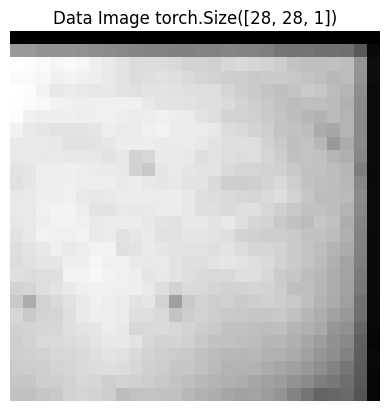

In [34]:
# Fetch a batch of data
data, target = next(iter(test_loader_skin))

# Print the shape of the batch
print("Batch of data images shape:", data.shape)
print("Batch of target images shape:", target.shape)
print(target)

sample = np.transpose(data[0, :, :, :], (1, 2, 0))

# Plot the moving image
plt.title(f'Data Image {sample.shape}')
plt.imshow(sample, cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

Train Epoch: 1 [0/1 (0%)]	Loss: 1.972106

Test set: Average loss: 1.8287, Accuracy: 1/1 (100%)

Train Epoch: 2 [0/1 (0%)]	Loss: 1.799128

Test set: Average loss: 1.5750, Accuracy: 1/1 (100%)

Train Epoch: 3 [0/1 (0%)]	Loss: 1.351010

Test set: Average loss: 1.2005, Accuracy: 1/1 (100%)

Train Epoch: 4 [0/1 (0%)]	Loss: 1.620587

Test set: Average loss: 1.1916, Accuracy: 1/1 (100%)

Train Epoch: 5 [0/1 (0%)]	Loss: 0.510880

Test set: Average loss: 0.7126, Accuracy: 1/1 (100%)

Train Epoch: 6 [0/1 (0%)]	Loss: 1.743553

Test set: Average loss: 0.7521, Accuracy: 1/1 (100%)

Train Epoch: 7 [0/1 (0%)]	Loss: 1.444508

Test set: Average loss: 0.6307, Accuracy: 1/1 (100%)

Train Epoch: 8 [0/1 (0%)]	Loss: 0.410584

Test set: Average loss: 0.3075, Accuracy: 1/1 (100%)

Train Epoch: 9 [0/1 (0%)]	Loss: 1.053405

Test set: Average loss: 0.1860, Accuracy: 1/1 (100%)

Train Epoch: 10 [0/1 (0%)]	Loss: 0.890924

Test set: Average loss: 0.1316, Accuracy: 1/1 (100%)

Train Epoch: 11 [0/1 (0%)]	Loss: 0.0700

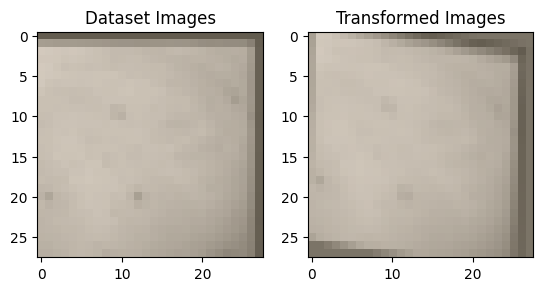

In [33]:
for epoch in range(1, 20 + 1):
    train(epoch, train_loader_skin)
    test(test_loader_skin)

# Visualize the STN transformation on some input batch
visualize_stn(test_loader_skin)

plt.ioff()
plt.show()

In [ ]:
# https://debuggercafe.com/spatial-transformer-network-using-pytorch/
# https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html

In [73]:
# class STN(nn.Module):
#     def __init__(self, num_channels=3):  
#         super(STN, self).__init__()

#         self.num_channels = num_channels

#         # Localization network
#         self.localization = nn.Sequential(
#             nn.Conv2d(num_channels, 8, kernel_size=7),
#             nn.MaxPool2d(2, stride=2),
#             nn.ReLU(True),
#             nn.Conv2d(8, 10, kernel_size=5),
#             nn.MaxPool2d(2, stride=2),
#             nn.ReLU(True)
#         )

#         # Calculate the input size for the fc_loc layer dynamically
#         input_size = self.calculate_input_size()

#         # Regressor for the 3x2 affine matrix
#         self.fc_loc = nn.Sequential(
#             nn.Linear(input_size, 32),
#             nn.ReLU(True),
#             nn.Linear(32, 3 * 2)
#         )

#     def calculate_input_size(self):
#         # Create a sample input tensor and pass it through the localization network
#         sample_input = torch.randn(1, self.num_channels, 224, 224)  # Adjust the size if needed
#         localization_output = self.localization(sample_input)

#         # Calculate the total number of elements in the output tensor
#         input_size = localization_output.view(localization_output.size(0), -1).size(1)
        
#         return input_size

#     def forward(self, x):
#         xs = self.localization(x)
#         xs = xs.view(xs.size(0), -1)
#         theta = self.fc_loc(xs).view(-1, 2, 3)

#         # Apply the transformation to the input image
#         grid = F.affine_grid(theta, x.size())
#         x = F.grid_sample(x, grid)

#         return x

In [72]:
# # experimenting MLP approach of SIREN implementation 
# class MLP(nn.Module):
#     def __init__(self, layers):
#         """Initialize the network."""

#         super(MLP, self).__init__()
#         self.n_layers = len(layers) - 1

#         # Make the layers
#         self.layers = []
#         for i in range(self.n_layers):
#             self.layers.append(nn.Linear(layers[i], layers[i + 1]))

#         # Combine all layers to one model
#         self.layers = nn.Sequential(*self.layers)

#     def forward(self, x):
#         """The forward function of the network."""

#         # Perform relu on all layers except for the last one
#         for layer in self.layers[:-1]:
#             x = torch.nn.functional.relu(layer(x))

#         # Propagate through final layer and return the output
#         return self.layers[-1](x)

In [74]:
# stn = STN(num_channels=3).to(device)
# mlp = MLP(layers=[3, 256, 256, 256, 3]).to(device)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [75]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [65]:
class ImageRegistrationDataset(Dataset):
    def __init__(self, fixed_images_dir, moving_images_dir, transform=None):
        self.fixed_images_dir = fixed_images_dir
        self.moving_images_dir = moving_images_dir
        self.transform = transform

        # Assuming images are in a common format like JPEG or PNG
        self.fixed_images = [os.path.join(fixed_images_dir, img) for img in os.listdir(fixed_images_dir)]
        self.moving_images = [os.path.join(moving_images_dir, img) for img in os.listdir(moving_images_dir)]

    def __len__(self):
        return len(self.fixed_images)

    def __getitem__(self, idx):
        fixed_image_path = self.fixed_images[idx]
        moving_image_path = self.moving_images[idx]

        fixed_image = Image.open(fixed_image_path).convert('RGB')
        moving_image = Image.open(moving_image_path).convert('RGB')

        if self.transform:
            fixed_image = self.transform(fixed_image)
            moving_image = self.transform(moving_image)

        return moving_image, fixed_image

In [66]:
# Assuming your data is in tensor format and you want to normalize it
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Specify the paths to your fixed and moving image datasets
fixed_images_dir = './fixed/'
moving_images_dir = './moving/'

# Create the dataset
image_registration_dataset = ImageRegistrationDataset(fixed_images_dir, moving_images_dir, transform=data_transform)

In [67]:
# Define batch size
batch_size = 32

# Create a data loader
data_loader = torch.utils.data.DataLoader(image_registration_dataset, batch_size=batch_size, shuffle=True)

In [68]:
# Fetch a batch of data
moving, fixed = next(iter(data_loader))

# Print the shape of the batch
print("Batch of moving images shape:", moving.shape)
print("Batch of fixed images shape:", fixed.shape)

Batch of moving images shape: torch.Size([1, 3, 894, 1090])
Batch of fixed images shape: torch.Size([1, 3, 894, 1090])


In [69]:
# Define the Mean Squared Error loss
criterion = nn.MSELoss()
num_epochs=1

In [77]:
def train(num_epochs):
    for epoch in range(num_epochs):
        total_loss = 0.0  # Initialize total loss for the epoch
        for batch_idx, (moving_image, fixed_image) in enumerate(data_loader):
            optimizer.zero_grad()
            moving_image = moving_image.to(device)
            fixed_image = fixed_image.to(device)
            output = model(moving_image)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 500 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            

In [78]:
for epoch in range(1, 20 + 1):
    train(epoch)

RuntimeError: Given groups=1, weight of size [8, 1, 7, 7], expected input[1, 3, 894, 1090] to have 1 channels, but got 3 channels instead